# Score-Matching Langevin Dynamics

In [34]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch.distributions.multivariate_normal import MultivariateNormal

## Langevin Dynamics using the true score function

We begin by implementing Langevin Dynamics which has theoretical guarantees as proven in the paper.

In [14]:
SAMPLES = 100
NUM_STEPS = 10000
LR = 0.01

### Implementation 1: 1D Langevin Dynamics Converging to GMM distribution
1D Gaussian mixture model with 0.5 chance being centered around 2 and 0.5 chance being centered around -2.

In [15]:
def langevin_dynamics(score, x, num_steps=NUM_STEPS, step_size=LR):
    """
    Langevin dynamics implemented as shown in Sohl-Dickstein et al. 2015
    """
    for _ in range(num_steps):
        score_x = score(x)
        x = x + 0.5 * step_size * torch.autograd.grad(score_x.sum(), x, create_graph=True)[0]
        x += np.sqrt(step_size) * torch.randn_like(x)
    return x

In [16]:
def mixture_of_gaussians(x):
    """
    Score function for a mixture of two Gaussians, one at -2 and one at 2 with unit variance and equal weights.
    """
    return torch.log(0.5 * torch.exp(-0.5 * (x - 2).pow(2)) + 0.5 * torch.exp(-0.5 * (x + 2).pow(2)))

We start by sampling points uniformly and show what the effect will be when performing Langevin Dynamics on them. Note that in theory we would've needed for the prior to be with the same support as the posterior, but empirically this doesn't seem to be too important.

In [17]:
def visualize_samples(samples):
    plt.hist(samples.detach().numpy(), bins=100, density=True)
    plt.show()

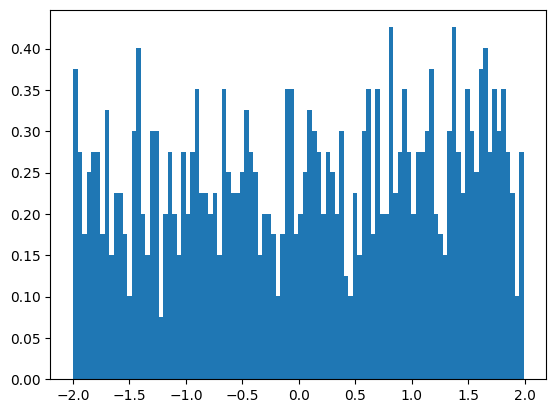

In [18]:
sample = torch.rand(1000, requires_grad=True) * 4 - 2
final = langevin_dynamics(mixture_of_gaussians, sample)
visualize_samples(sample)

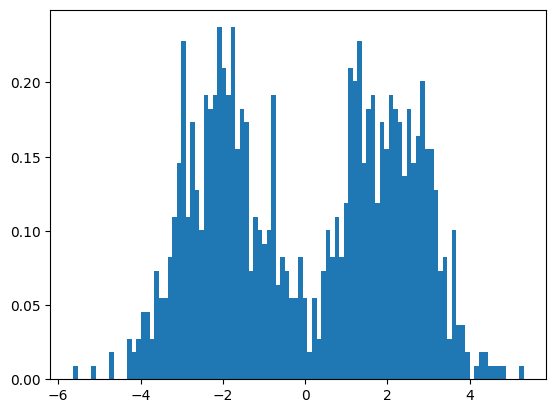

In [19]:
visualize_samples(final)

### Implementation 2: Multivariate Langevin Dynamics
2D multivariate normal, GMM with 0.5 chance of being centered at (-1, -1) and 0.5 of being centered at (1, 1). Both have low variance for them to have essentially disjoint supports.

In [20]:
def mixture_of_gaussians2(x, mu1, mu2, sigma1, sigma2, p1):
    normal1 = MultivariateNormal(mu1, sigma1 * torch.eye(mu1.shape[0]))
    normal2 = MultivariateNormal(mu2, sigma2 * torch.eye(mu2.shape[0]))

    return torch.log(p1 * torch.exp(normal1.log_prob(x)) + (1 - p1) * torch.exp(normal2.log_prob(x)))

In [21]:
sample = torch.randn(1000, 2, requires_grad=True)
mu1, sigma1 = torch.tensor([1., 1.]), 0.1
mu2, sigma2 = torch.tensor([-1., -1.]), 0.1
p1 = 0.5
final = langevin_dynamics(lambda x: mixture_of_gaussians2(x, mu1, mu2, sigma1, sigma2, p1), sample)

In [22]:
def visualize_samples2(samples):
    plt.scatter(samples.detach().numpy()[:, 0], samples.detach().numpy()[:, 1], edgecolors='black', facecolors='none', alpha=0.5, s=1)
    plt.show()

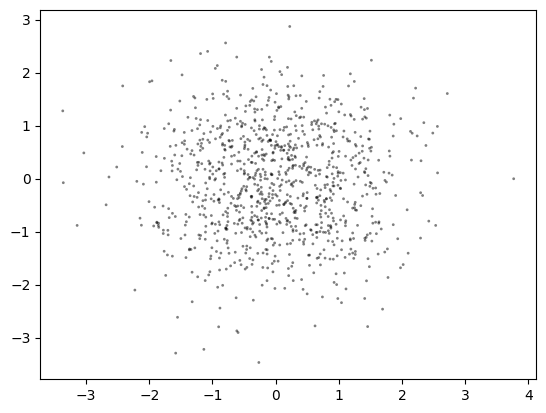

In [23]:
visualize_samples2(sample)

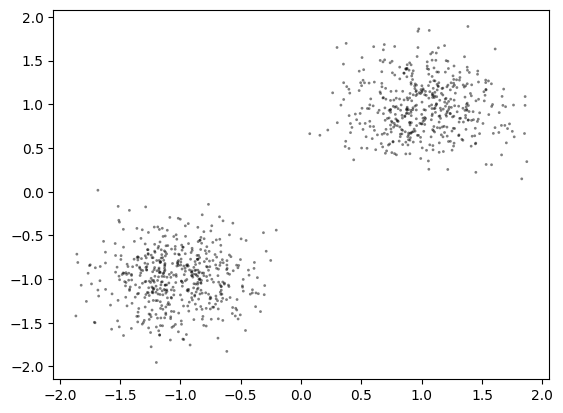

In [24]:
visualize_samples2(final)

### Implementation 3: Imbalanced GMM
What happens when the probability of being in one cluster are higher? This information is supposed to be hard to obtain in the process of taking the gradient.

In [25]:
sample = torch.randn(1000, 2, requires_grad=True)
p1 = 0.1

final = langevin_dynamics(lambda x: mixture_of_gaussians2(x, mu1, mu2, sigma1, sigma2, p1), sample)

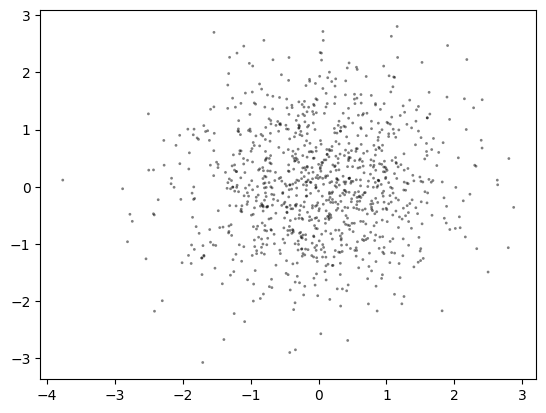

In [26]:
visualize_samples2(sample)

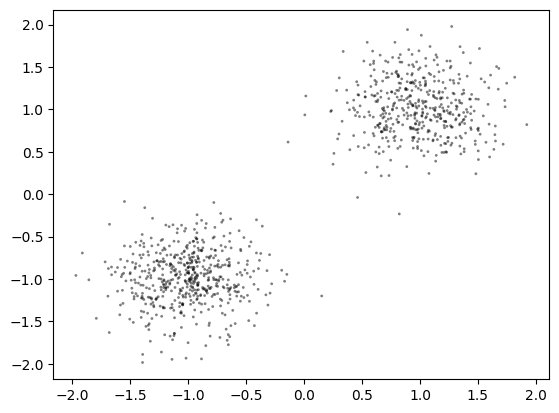

In [27]:
visualize_samples2(final)

It is still equally divided. The distribution is supposed to appear as follows:

In [28]:
true_prob = torch.rand(1000) < p1
true_prob = true_prob.float()

normal1 = MultivariateNormal(mu1, sigma1 * torch.eye(mu1.shape[0]))
normal2 = MultivariateNormal(mu2, sigma2 * torch.eye(mu2.shape[0]))


true_sample = torch.stack([normal1.sample() if p else normal2.sample() for p in true_prob])

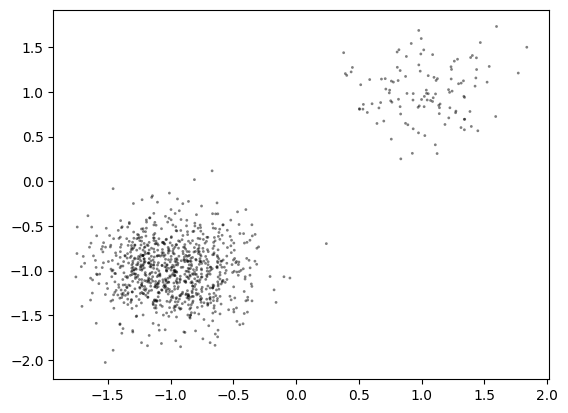

In [29]:
visualize_samples2(true_sample)

### Implementation 4: Noise Conditional Langevin Dynamics
Add decreasing noise to the data until convergence.

In [30]:
def annealed_langevin_dynamics(score, x, sigmas, num_steps=NUM_STEPS, step_size=LR):
    for sigma in sigmas:
        eps = (sigma / sigmas[-1]) ** 2 * step_size if sigma > 0 else step_size
        for _ in range(num_steps):
            score_x = score(x, sigma)
            x = x + 0.5 * eps * torch.autograd.grad(score_x.sum(), x, create_graph=True)[0]
            x += np.sqrt(eps) * torch.randn_like(x)
        plt.scatter(x.detach().numpy()[:, 0], x.detach().numpy()[:, 1], edgecolors='black', facecolors='none', alpha=0.5, s=1)
        plt.title(f"sigma = {sigma}")
        plt.show()
    return x

In [31]:
def mixture_of_gaussians3(x, noise):
    normal1 = MultivariateNormal(mu1, (noise + sigma1) * torch.eye(mu1.shape[0]))
    normal2 = MultivariateNormal(mu2, (noise + sigma2) * torch.eye(mu2.shape[0]))

    return torch.log(p1 * torch.exp(normal1.log_prob(x)) + (1 - p1) * torch.exp(normal2.log_prob(x)))

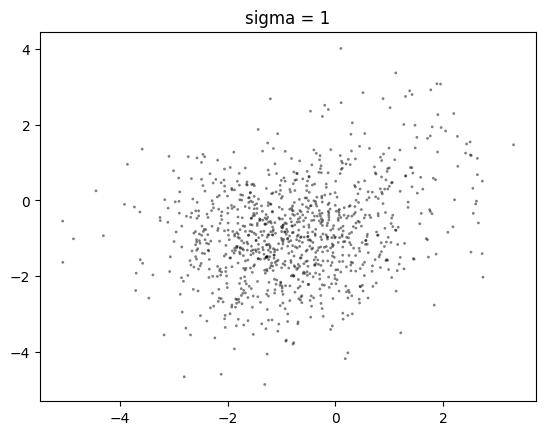

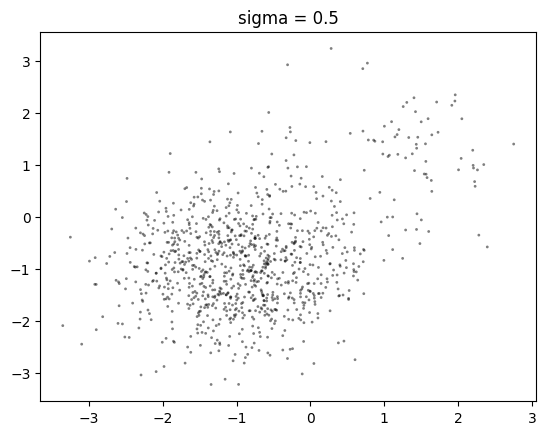

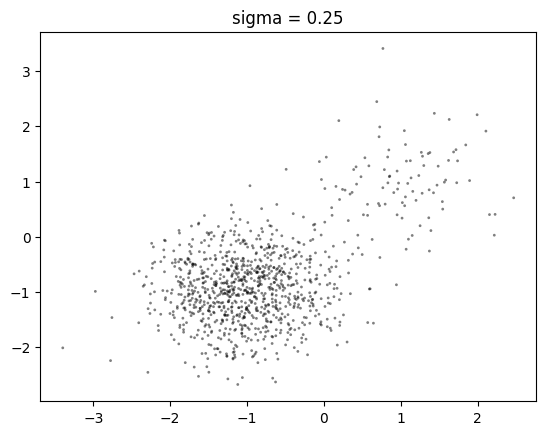

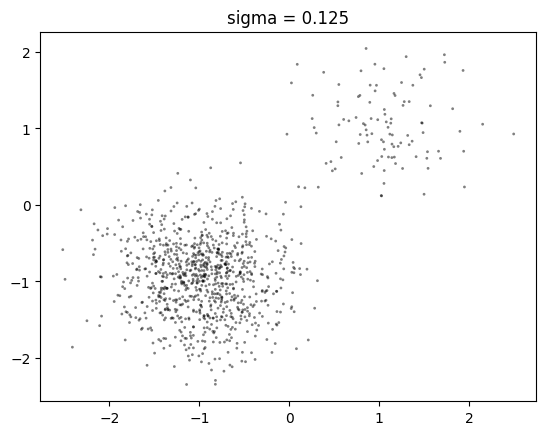

In [32]:
sample = torch.randn(1000, 2, requires_grad=True)
sigmas = [1, 0.5, 0.25, 0.125]
result = annealed_langevin_dynamics(mixture_of_gaussians3, sample, sigmas)

We can see that the annealed Langevin Dynamics do much better at estimating the distribution when it is not "even".

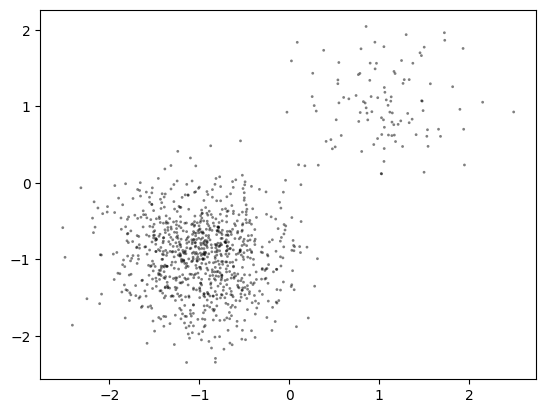

In [33]:
visualize_samples2(result)

## Langevin Dynamics using a score matcher

Now, we will implement a score-matching mechanism and use it to run Langevin Dynamics

We will start by implementing regular SMLD on the multivariate Gaussian, then use something more complicated for more complex distributions.

In [ ]:
class FullyConnectedScoreMatcher(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(FullyConnectedScoreMatcher, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = input_dim

        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, input_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def langevin_dynamics(self, x, num_steps=NUM_LANGEVIN, step_size=LANGEVIN_STEP):
        for _ in range(num_steps):
            score = self(x)
            x = x + step_size * score + torch.randn_like(x) * np.sqrt(2 * step_size)
        return x
    
    def sample(self, num_samples=SAMPLES):
        x = torch.randn(num_samples, self.input_dim)
        return self.langevin_dynamics(x)
    
    

In [10]:
train_X = torch.tensor(np.random.randn(1000, 2), dtype=torch.float32, requires_grad=True)

# get the score function of the standard normal distribution
distribution = MultivariateNormal(torch.zeros(2), 2*torch.eye(2))
score = torch.autograd.grad(distribution.log_prob(train_X).sum(0), train_X)[0]

model = FullyConnectedScoreMatcher(2, 128)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion